# ADCS Simulator and System Modeling / Selection Notebook 
Follow the readme to install dependencies and correctly configure you environment/machine to run the varios blocks.

In [1]:
%matplotlib widget
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import lib.physics as physics
import lib.cubesat as cubesat
import lib.renderer as renderer
import lib.plots as plots

In [32]:
def vcircular(altitude):
    '''
    This is a test:
    >>> vcircular(100)
    7909.618746598862
    '''
    return math.sqrt(physics.Consts.mu / (altitude + physics.Consts.R_earth))

initial_state  = cubesat.State(physics.Consts.ISS_altitude + physics.Consts.R_earth, 0, 0, 0, vcircular(physics.Consts.ISS_altitude), 0) # x, y, z, dx, dy, dz
qubesat = cubesat.Cubesat(1, length=0.1, width=0.1, height=0.1) # mass in kg, length, width, height in m

planet  = physics.Planet(physics.Consts.M_earth, physics.Consts.R_earth) # mass in kg, radius in meters
# planet  = physics.Planet(10, 200) # mass in kg, radius in meters

# import doctest
# doctest.testmod(verbose=True)

import unittest
class TestNotebook(unittest.TestCase):
    
    def test_vcircular(self):
        self.assertEqual(vcircular(10), 7909.674613971004)
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_vcircular (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


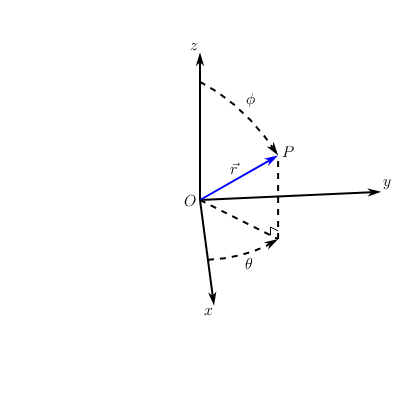

http://dynref.engr.illinois.edu/rvs.html

https://fgiesen.wordpress.com/2012/08/24/quaternion-differentiation/

https://gafferongames.com/post/physics_in_3d/

http://www.cs.cmu.edu/~baraff/sigcourse/notesd1.pdf

![image info](./images/quaternion_around_n.png)

![image info](./images/quat_vel.png)

[Direction Cosine Matrix ECEF to NED](https://www.mathworks.com/help/aeroblks/directioncosinematrixeceftoned.html#mw_d64661e2-b42c-4e16-925c-0f40d40a285c)

![image info](./images/dcm_ecef_to_ned.png)

https://www.mathworks.com/help/aeroblks/axes-transformations-1.html?s_tid=CRUX_lftnav

![image info](./images/quaternion_update_1.png)

![image info](./images/quaternion_update_2.png)

![image info](./images/lat_long.png)



In [40]:
class State:
    def __init__(self, x, y, z, dx, dy, dz, qw, qx, qy, qz, wx, wy, wz):
        """
        Structure of the state vector (units are m and m/s)
        x, y, z, dx, dy, dz
        Rotations is experssed as theta around n, where n is a unit vector
        """
        # nativelly contain the state as a cartesian state vector
        self.state_vector = np.array([x, y, z, dx, dy, dz])
        self.w = np.array([wx, wy, wz])
        self.q = np.array([qw, qx, qy, qz])
        
        
    def get_cartesian_state_vector(self):
        """
        Structure of the state vector (units are m and m/s)
        x, y, z, dx, dy, dz
        """
        return self.state_vector
    
    def get_orientation_quaternion(self):
        return self.q
    
    def get_angular_velocity_vector(self):
        return self.w
    
    def get_spherical_state_vector(self):
        """
        Structure of the earth referenced state vector (units are m, radians, and m/s)
        r (radius from the center of the plant), theta (latitude), phi (longitude), dr, dtheta, dphi
        
        Good reference http://dynref.engr.illinois.edu/rvs.html
        https://physics.stackexchange.com/questions/546479/conversion-of-cartesian-position-and-velocity-to-spherical-velocity
        """
        r = np.linalg.norm(self.state_vector[:3])
        theta = np.arctan2(self.get_y(), self.get_x()) # latitude
        phi = np.arccos(self.get_z()/r) # longitude
        
        ############### WRONG ################
        dr = 2*(self.get_x()*self.get_dx() + self.get_y()*self.get_dy() + self.get_z()*self.get_dz()) / r
        dtheta = 1/(1 + (self.get_y()/self.get_x())**2)*(self.get_dy()/self.get_x() - self.get_dx()/self.get_x()**2)
        dphi = -1/(np.sqrt(1-(self.get_z()/r)**2))*(self.get_dz()/r-self.get_z()*dr/r**2)
        ############### WRONG ################
        return np.array([r, theta, phi, dr, dtheta, dphi])

    # Getter methods for cartesian coordinates 
    def get_x(self):
        return self.state_vector[0]
    
    def get_y(self):
        return self.state_vector[1]

    def get_z(self):
        return self.state_vector[2]
    
    def get_dx(self):
        return self.state_vector[3]
    
    def get_dy(self):
        return self.state_vector[4]
    
    def get_dz(self):
        return self.state_vector[5]
    
    # Getter methods for spherical coordinates
    def get_r(self):
        return self.get_spherical_state_vector()[0]
    
    def get_altitude(self, planet):
        return self.get_r() - planet.radius
    
    def get_theta(self):
        return self.get_spherical_state_vector()[1]
    
    def get_lat(self):
        return math.pi/2 - self.get_phi()

    def get_phi(self):
        return self.get_spherical_state_vector()[2]
    
    def get_lon(self):
        return self.get_theta()
    
    def get_dr(self):
        return self.get_spherical_state_vector()[3]
    
    def get_dtheta(self):
        return self.get_spherical_state_vector()[4]
    
    def get_dphi(self):
        return self.get_spherical_state_vector()[5]
    
    # NED for magnetic field
    # np.dot(T, vector in NED) results in vector in ECEF
    def ned_to_ecef(self):
        lon = self.get_lon()
        lat = self.get_lat()
        DCMned = np.linalg.inv(np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
                                         [-np.sin(lon), np.cos(lon), 0],
                                         [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]])) 
        return np.dot(DCMned, vector)
    
    # np.dot(T, vector in ECEF) results in vector in NED
    def ecef_to_ned(self, vector):
        lon = self.get_lon()
        lat = self.get_lat()
        DCMef = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
                          [-np.sin(lon), np.cos(lon), 0],
                          [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]]) 
        return np.dot(DCMef, vector)
    
def state_from_vectors(state, q, w):
    return State(state[0], state[1], state[2], state[3], state[4], state[5], q[0], q[1], q[2], q[3], w[0], w[1], w[2])

In [41]:
import pyIGRF

"""
the response is 7 float number about magnetic filed which is: 
- D: declination (+ve east) 
- I: inclination (+ve down) 
- H: horizontal intensity 
- X: north component 
- Y: east component 
- Z: vertical component (+ve down) 
- F: total intensity unit: degree or nT
"""
print(pyIGRF.igrf_value(0, 0, physics.Consts.ISS_altitude, 2019))

(-9.042033569666227, 5.5812152359476785, 0.00011284596737048032, 0.00011144366559623345, -1.7734761071252162e-05, 1.1027292125251382e-05, 0.00011338347994040023)


In [42]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

class Simulator:
    def __init__(self, cubesat, planet, state, dt=0.1):
        """
        time and step size in seconds
        """
        self.dt = dt
        self.cubesat = cubesat
        self.planet = planet
        self.elapsed_time = 0
        self.state = state
        # functions that take in a state and returns a force vector <Fx,Fy,Fz> acting on the COM of the cubesat
        self.forces = []
        # functions that take in a state and returns an acceleration vector <ax,ay,az> acting on the COM of the cubesat
        self.accelerations = []
        # function that takes in a state and returns a torque vector <tx, ty, tz> acting around the COM of the cubesat with inertia I 
        self.torques = []
        # function that takes in a state and returns an angular acceleration vector <alphax, alphay, alphaz> acting around the COM
        self.angular_accelerations = []
        
        # The new state is provided by the following equation
        # xk = Axk-1 + Buk-1 + wk-1
        # u is the vector sum of all the accelerations
        
        # 3D state matrix - A
        self.A = np.array([[1, 0, 0, self.dt, 0, 0],
                          [0, 1, 0, 0, self.dt, 0],
                          [0, 0, 1, 0, 0, self.dt],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]]) 
        
        # 3D control matrix - B
        self.B = np.array([[1/2*self.dt**2, 0, 0],
                          [0, 1/2*self.dt**2, 0],
                          [0, 0, 1/2*self.dt**2],
                          [self.dt, 0, 0],
                          [0, self.dt, 0],
                          [0, 0, self.dt]])
        
    def step(self):
        # compute acceleration vector from gravity assuming points mass of the earth and satelite
        # [x,y,z]/|[x,y,z]| <- assumes point mass earth with center at (0,0,0)

        net_force = np.zeros(3)
        for forcer in self.forces:
            net_force += forcer(self.state, self.cubesat, self.planet)
            
        net_acc = np.zeros(3)
        for accelerator in self.accelerations:
            net_acc += accelerator(self.state, self.cubesat, self.planet)
            
        net_acc += net_force / self.cubesat.mass
        
        net_torque = np.zeros(3)
        for torquer in self.torques:
            net_torque += torquer(self.state, self.cubesat, self.planet)
            
        net_angular_acc = np.zeros(3)
        for angular_accelerator in self.angular_accelerations:
            net_angular_acc += angular_accelerator(self.state, self.cubesat, self.planet)

        net_angular_acc += np.dot(self.cubesat.inertia_inv, net_torque)  
        
        angular_velocity = self.state.get_angular_velocity_vector() + net_angular_acc*self.dt

        # https://math.stackexchange.com/questions/39553/how-do-i-apply-an-angular-velocity-vector3-to-a-unit-quaternion-orientation
        w = angular_velocity * self.dt
        w_norm = np.linalg.norm(w)
        w_f = w * np.sin(w_norm/2)/w_norm if w_norm != 0 else [0, 0, 0]
        q = quaternion_multiply(np.array([np.cos(w_norm/2), w_f[0], w_f[1], w_f[2]]), self.state.get_orientation_quaternion())
        q /= np.linalg.norm(q)
                
        # A*state + B*acceleration 
        self.state = state_from_vectors(np.dot(self.A, self.state.get_cartesian_state_vector()) + np.dot(self.B, net_acc), q, angular_velocity)
        self.elapsed_time += self.dt
        return (self.elapsed_time, self.state)
    
    def add_forcer(self, forcer):
        self.forces.append(forcer)
        
    def add_accelerator(self, accelerator):
        self.accelerations.append(accelerator)
        
    def add_torquer(self, torquer):
        self.torques.append(torquer)
        
    def add_angular_accelerator(self, angular_accelerator):
        self.angular_accelerations.append(angular_accelerator)

In [43]:
def quaternion_to_euler_angle(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)

    t2 = np.clip(t2, a_min=-1.0, a_max=1.0)
    Y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.arctan2(t3, t4)

    return X, Y, Z
        
class OrientationPlot:
    def __init__(self, inclination=0):
        self.is_3d = False
    
    def build(self, states, time_stamps, ax):
                
        X, Y, Z = [], [], []
        for state in states:
            q = state.get_orientation_quaternion()
            x,y,z  = quaternion_to_euler_angle(q[0], q[1], q[2], q[3])
            X.append(x)
            Y.append(y)
            Z.append(z)
        
        ax.plot(time_stamps, X, color="red", label='x')
        ax.plot(time_stamps, Y, color="green", label='y')
        ax.plot(time_stamps, Z, color="blue", label='z')

        ax.set_title("Orientation Plot")
        ax.set_xlabel("time (s)")
        ax.set_ylabel("radians")
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)

In [44]:
def gravitational_forcer(state, cubesat, planet):
    return planet.get_gravitational_acceleration(state)

def euler_to_quaternion(roll, pitch, yaw):

        qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
        qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
        qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
        qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

        return (qw, qx, qy, qz)

def inclination_to_cartesian_velocity(speed, inclination):
    return (0, speed*math.cos(inclination), speed*math.sin(inclination))
vx, vy, vz = inclination_to_cartesian_velocity(vcircular(physics.Consts.ISS_altitude), math.pi/2)


qw, qx, qy, qz = euler_to_quaternion(0, 0, 0)
# x, y, z, dx, dy, dz, qw, qx, qy, qz, wx, wy, wz
state = State(physics.Consts.ISS_altitude + physics.Consts.R_earth, 0, 0, vx, vy, vz, qw, qx, qy, qz, 0.001, 0.000, 0.000)
simulator = Simulator(qubesat, planet, state, 1)
simulator.add_accelerator(gravitational_forcer)

stop_condition = lambda states, times: len(states) > 10000
r = renderer.Renderer()
r.run(simulator, stop_condition)
plot1 = plots.CartesianPlot()
r.add_plot(plot1)
plot2 = plots.CartesianVelocityPlot()
r.add_plot(plot2)
plot3 = plots.SphericalPlot()
r.add_plot(plot3)
print("Spherical Velocities are Incorrect")
plot4 = plots.SphericalVelocityPlot()
r.add_plot(plot4)
plot5 = plots.OrbitalPlot2D(planet, inclination=physics.Consts.ISS_inclination)
r.add_plot(plot5)
plot6 = plots.OrbitalPlot3D(planet)
r.add_plot(plot6)
plot7 = OrientationPlot()
r.add_plot(plot7)

r.render(figsize=(15,25), columns=2)

Spherical Velocities are Incorrect


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# References
[Passive Magentic Attitude Control fro Cubesat Spacecraft](https://lasp.colorado.edu/home/csswe/files/2012/06/Gerhardt_SSC10_PMAC.pdf)

[Comparison of Control Laws for Magnetic Detumbling](https://www.researchgate.net/publication/263008407_Comparison_of_Control_Laws_for_Magnetic_Detumbling)

[Using Rotations to Build Aerospace Coordinate Systems](https://apps.dtic.mil/dtic/tr/fulltext/u2/a484864.pdf)


https://docs.google.com/document/d/16QsLCta1YLF__5pwcChfcjYQvqa9x6MZi19Ohj2Yuls/edit

https://www.youtube.com/playlist?list=PL_D7_GvGz-v3mDQ9iR-cfjXsQf4DeR1_H

https://pypi.org/project/pyIGRF/

https://stackoverflow.com/questions/53074908/map-an-image-onto-a-sphere-and-plot-3d-trajectories
